# Analysis of Union College math major student data

## Part 3 - Exploratory data analysis

### Set up the notebook environment

In [1]:
# Imports
from IPython.display import HTML 
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import union_constants as uc

In [2]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [3]:
# Load data - cleaned in part 1
cleaned_data_fn = 'data/union_students_818_cleaned.xlsx'
info = pd.read_excel(cleaned_data_fn, sheet_name='info')
grades = pd.read_excel(cleaned_data_fn, sheet_name='grades')

### Counting things

To get a feel for the data and see if anything looks interesting

#### Number of students

In [4]:
# Unique students
info_num_students = len(info.id.unique())
grade_num_students = len(grades.id.unique())
print('Total number of students in the student info data = {0}'
      .format(info_num_students))
print('Total number of students in the student grades data = {0}'
      .format(grade_num_students))
print()
print('Number of students who left without graduating = {0}'
      .format(len(info.loc[info.left_wo_grad == 'Y'])))

Total number of students in the student info data = 110
Total number of students in the student grades data = 110

Number of students who left without graduating = 1


#### Student majors

* It looks like each students major(s) are encoded as a single string. With the key this section might be rewritten to break down code by major which could be more useful going forward. 

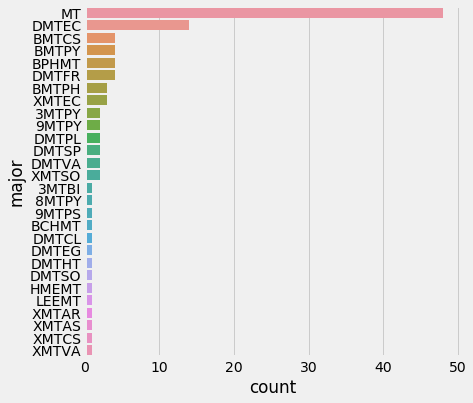

In [36]:
# Students by major
ax = sns.barplot(y='major', x='count',
                 data=(info
                       .major.value_counts()
                       .to_frame(name='count').reset_index()
                       .rename(columns={'index':'major'})
                       .sort_values(['count', 'major'], 
                                    ascending=[False, True])
                      )
                 )                
plt.show()

#### Number of times each faculty appears in the data
* The same student taking the same professor multiple times counts each time
* Remember data does not include minors or non-majors
  + not a reflection of how many total students were taught by professor


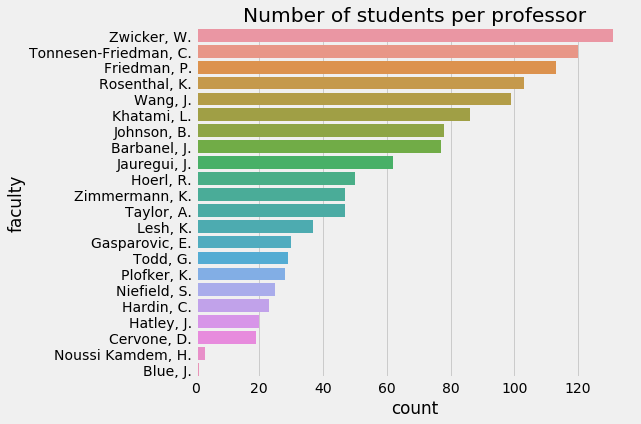

In [6]:
# Faculty counts
plt.figure(figsize=(7.0, 6.0))
sns.countplot(y='faculty', data=grades, 
              order=grades.faculty.value_counts().index)
plt.title('Number of students per professor')
plt.show()

#### Student class (year)
* Labeled as "class - not grad year necessarily"
  + Guessing this is expected graduation year based on four years from matriculation
  + Probably explains a few students from 2010, 2013 and 2019 classes. 

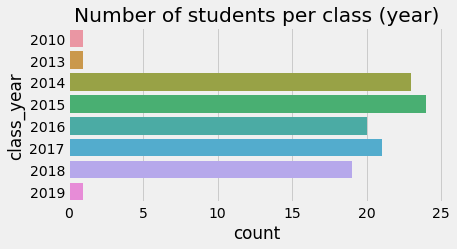

In [7]:
# Class year
plt.figure(figsize=(6.0, 3.0))
sns.countplot(y='class_year', data=info, order=info.class_year.unique().sort())
plt.title('Number of students per class (year)')
plt.show()

#### Greek affiliations

Most students unaffiliated. Might be recast as unaffiliated vs. affiliated if looking for correlations.

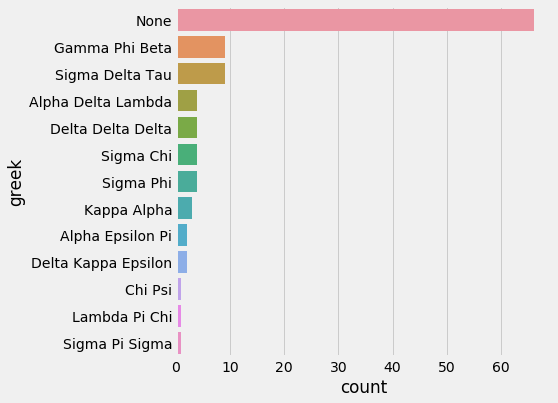

Number of students with a Greek affiliation = 44
Number of students without a Greek affiliation = 66


In [8]:
# Greek affiliations
ax = sns.barplot(y='greek', x='count', 
                 data=(info
                       .fillna('None')
                       .greek
                       .value_counts()
                       .to_frame(name='count')
                       .reset_index()
                       .rename(columns={'index':'greek'})
                       .sort_values(['count', 'greek'], ascending=[False, True])
                      )
                )
plt.show()

print('Number of students with a Greek affiliation = {0}'
      .format(info.greek.notnull().sum()))
print('Number of students without a Greek affiliation = {0}'
      .format(info.greek.isnull().sum()))

#### Students interests

* Combined all six interest columns and excluded Na for counts. 
* Most interests were expressed by only a few students, but a few many be large enough to look for correlations. 
* Some interests might be grouped (i.e. different Houses, Greek affiliations).

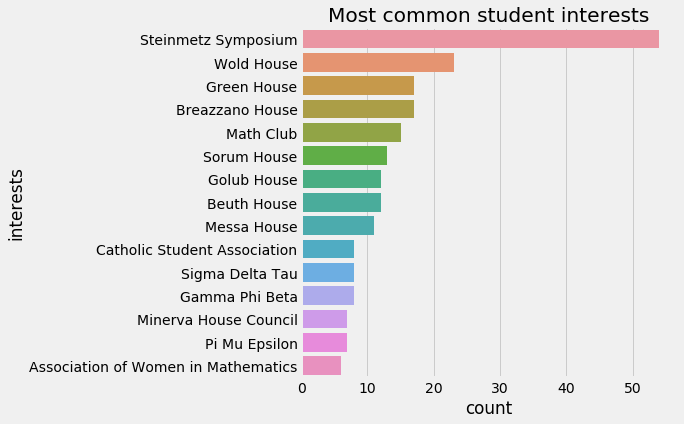

In [9]:
# Students interests count
interest_data = (info.loc[:, 'interest_1':'interest_6']
                 .stack().to_frame(name='interests'))

sns.countplot(y='interests', data=interest_data,
              order=(interest_data.interests.value_counts().index)[:15])
plt.title('Most common student interests')
plt.show()

#### Employers and job titles

* As is, these are very specific to each student. 
  + Each company only employs a single student
  + Only a few students share exact same job titles
<br><br>
* However they could be grouped if someone were to assign membership
  + i.e. Employers might be grouped by business sector
  + i.e. Titles like 'Teacher' and 'Middle School Teacher' could be combined into 'Teaching'
<br><br>  
* Missing information on students who went to graduate school

In [10]:
# Most common employers
if (info.employer.value_counts() > 1).any():
    print('Most common employers:')
    display(info.employer.value_counts().sort_values(ascending=False)[:5]
            .to_frame(name='count'))
else:
    print('No two students employed by the same company')
    
# # List of all employers
# print()
# print('\n'.join([employer.replace(',','') for employer in 
#                  info.loc[info.employer.notnull()]
#                      .employer.sort_values().unique()]))

No two students employed by the same company


In [11]:
# Most common titles
if (info.title.value_counts() > 1).any():
    print('Most common titles:')
    display(info.title.value_counts().loc[info.title.value_counts() > 1]
            .to_frame(name='count')[:5])
else:
    print('No two students with the exact same job title')
    
# # List of all titles
# print('\n'.join([title.replace(',','') for title in 
#                 info.loc[info.title.notnull()].title.sort_values().unique()]))

Most common titles:


,count
Analyst,3
Software Developer,2


#### Number of times each course was taken

* Some courses taken only a few or even a single time by majors in the give data
* Students repeating a course count twice

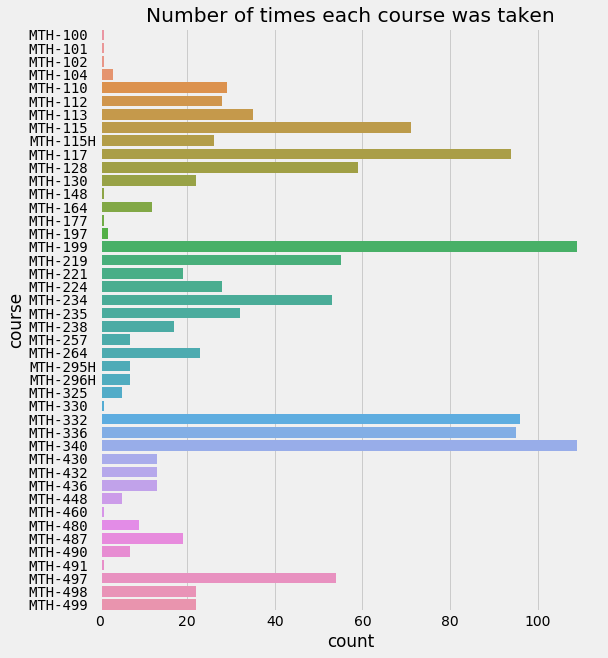

In [12]:
# Courses taken
min_count = 1   # exclude courses taken less than min_count times
graph_data = (grades
              # hack for left aligned tick labels, pad + use monospace font
              .assign(course = lambda srs: srs.course.str.pad(8, 'right'))
              .groupby('course').filter(lambda group: len(group) >= min_count)
             )

plt.figure(figsize=(8.0, 10.0))
ax = sns.countplot(y='course', 
              data=graph_data,
              order=sorted(graph_data.course.unique())   # By course number 
              #order=graph_data.course.value_counts().index    # By count
             )

for tick in ax.get_yticklabels():
    tick.set_fontname('DejaVu Sans Mono')

plt.title('Number of times each course was taken')
plt.show()

#### Grades

* The number of times each letter grade was awarded combined across all courses. 
* Looks like math majors tend to do well in math courses. Not too surprising.

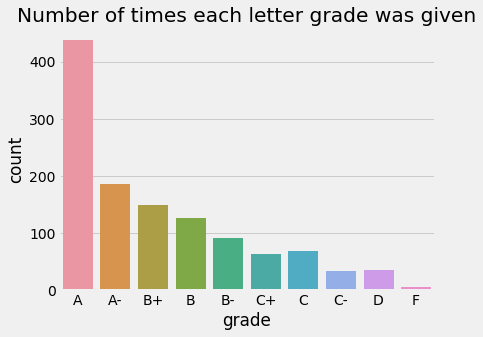

In [13]:
# Grades
plt.figure(figsize=(6.0, 4.5))
sns.countplot(x='grade', data=grades, order=uc.grade_rank)
plt.title('Number of times each letter grade was given')
plt.show()

#### Fails and retakes

* As it's a short list, table of all students who failed a course and any subsequent retakes

In [14]:
# Fails and Retakes
fails = grades.loc[grades.grade=='F'].loc[:, ['id', 'course']].values
fails = [tuple(array) for array in fails]
grades['temp'] = grades.apply(lambda row: (row.id, row.course), axis=1)

print('Fails and retakes table:')
with pd.option_context('max_row', 20):
    display(HTML(grades.loc[grades['temp'].isin(fails)]
                 .drop('temp', axis=1)
                 .to_html(index=False)))
    
grades.drop('temp', axis=1, inplace=True)
print()

Fails and retakes table:


id,course,faculty,term,year,date,grade,point
22,MTH-336,"Taylor, A.",FA,2012,2012-09-01,F,0.0
22,MTH-336,"Tonnesen-Friedman, C.",FA,2013,2013-09-01,A-,3.7
31,MTH-497,"Johnson, B.",SP,2015,2015-04-01,F,0.0
31,MTH-497,"Johnson, B.",FA,2015,2015-09-01,F,0.0
79,MTH-115,"Zwicker, W.",SP,2015,2015-04-01,F,0.0
79,MTH-115,"Zwicker, W.",SP,2016,2016-04-01,B+,3.3
101,MTH-117,"Friedman, P.",WI,2015,2015-01-01,F,0.0
101,MTH-117,"Plofker, K.",SP,2016,2016-04-01,B-,2.7
109,MTH-332,"Khatami, L.",SP,2014,2014-04-01,F,0.0
109,MTH-332,"Khatami, L.",SP,2015,2015-04-01,B-,2.7


### Grades by term (Fall / Winter / Spring)

* Investigating if the term affects the distribution of grades.
  + It doesn't look like that's the case here.

In [15]:
# Counts of letter grade by term
print('Count by term:')
display(grades.pivot_table('id', 'term', 'grade', aggfunc='count')
              .loc[uc.term_order_nosu, :]
              .reindex(columns=uc.grade_rank + ['P'], fill_value=0))

print('Percentage by term (not including "P"):')
with pd.option_context('display.float_format', '{:,.1f}'.format):
    display(grades
            .drop(grades.loc[grades.grade == 'P'].index)
            .pivot_table('id', 'term', 'grade', aggfunc=len)
            .apply(lambda srs: srs / sum(srs) * 100, axis=1)
            .loc[uc.term_order_nosu, :]
            .reindex(columns=uc.grade_rank, fill_value=0.0)
           )

Count by term:


grade,A,A-,B+,B,B-,C+,C,C-,D,F,P
term,,,,,,,,,,,
FA,135.0,66.0,55.0,39.0,27.0,18.0,27.0,8.0,14.0,2.0,24.0
WI,165.0,62.0,51.0,46.0,25.0,24.0,24.0,12.0,11.0,1.0,7.0
SP,137.0,55.0,44.0,41.0,39.0,22.0,17.0,13.0,10.0,3.0,2.0


Percentage by term (not including "P"):


grade,A,A-,B+,B,B-,C+,C,C-,D,F
term,,,,,,,,,,
FA,34.5,16.9,14.1,10.0,6.9,4.6,6.9,2.0,3.6,0.5
WI,39.2,14.7,12.1,10.9,5.9,5.7,5.7,2.9,2.6,0.2
SP,36.0,14.4,11.5,10.8,10.2,5.8,4.5,3.4,2.6,0.8


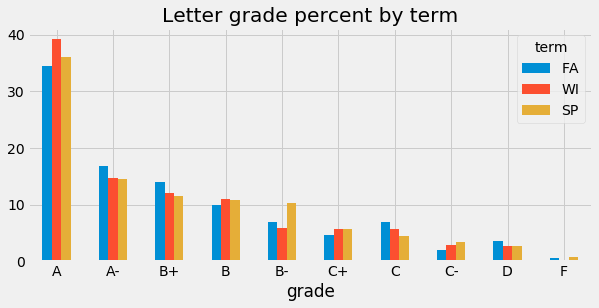

In [16]:
# Letter grade by term as percentage of grades from that term
(grades
 .drop(grades.loc[grades.grade == 'P'].index)
 .pivot_table('id', 'term', 'grade', aggfunc=len)
 .loc[uc.term_order_nosu, :]
 .reindex(columns=uc.grade_rank, fill_value=0.0)
 .apply(lambda srs: srs / sum(srs) * 100, axis=1)).T.plot.bar(figsize=(9, 4))
plt.title('Letter grade percent by term')
plt.xticks(rotation=0)
plt.show()

In [17]:
# Grade point by term summary statistics
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(grades.groupby('term').point.agg('describe')
           .loc[uc.term_order_nosu])

,count,mean,std,min,25%,50%,75%,max
term,,,,,,,,
FA,391.00,3.27,0.83,0.00,3.00,3.70,4.00,4.00
WI,421.00,3.32,0.80,0.00,3.00,3.70,4.00,4.00
SP,381.00,3.26,0.83,0.00,2.70,3.70,4.00,4.00


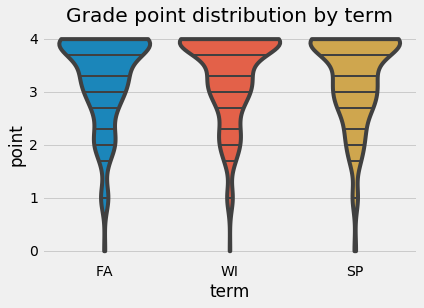

In [18]:
# Grade point by term distribution
plt.figure(figsize=(6, 4))
sns.violinplot(x='term', y='point', data=grades, order=uc.term_order_nosu,
               inner='sticks', scale='area', cut=0)
plt.title('Grade point distribution by term')
plt.show()

### Grade point by course

* Investigating how the distribution of grades varies by course
  + Only looking at subset of courses selected based on major requirements 
    * Just to save space, could be extended to cover more courses.
<br><br>
* Only a single individual followed the MTH-100, MTH-101, MTH-102 path
  + So the sampling is not representative 
<br><br>
* MTH-113 students received lower grades on average than those on the MTH-110 MTH-112 option.
  + Would be interesting to calculate the effect size and confidence
<br><br>
* MTH-115H students received higher grades on average than MTH-115.
  + Likely this reflects why they took the honors course and not the course difficulty

In [19]:
# Counts and percent of letter grade by course as tables
display_tables = False
if display_tables:
    print('Count by course:')
    with pd.option_context('display.float_format', '{:,.0f}'.format,
                           'max_rows', 15):
        display(grades
                .pivot_table('id', 'course', 'grade', aggfunc='count')
                .loc[uc.courses_select, :]
                .reindex(columns=uc.grade_rank + ['P'], fill_value=0)
                .fillna(0)
           )

    print('Percentage by course (not including "P"):')
    with pd.option_context('display.float_format', '{:,.1f}'.format,
                           'max_rows', 15):
        display(grades
                .drop(grades.loc[grades.grade == 'P'].index)
                .loc[grades.course.isin(uc.courses_select)]
                .pivot_table('id', 'course', 'grade', aggfunc='count',
                             fill_value=0)
                .apply(lambda srs: srs / sum(srs) * 100, axis=1)
                .reindex(columns=uc.grade_rank, fill_value=0.0)
          )

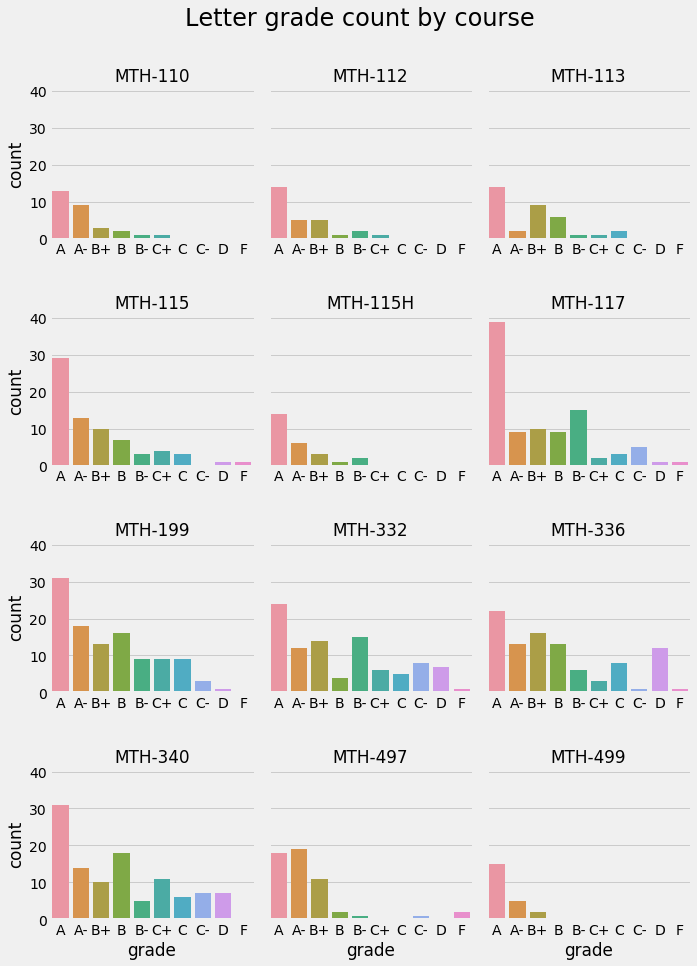

In [20]:
# Graph count of letter grade by course 
def mini_countplot(x, order, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    sns.countplot(x=x, data=data, order=order, ax=ax)
    
g = sns.FacetGrid(grades.loc[grades.course.isin(uc.courses_select)],
                  col='course', col_wrap=3, height=3.2,
                  col_order=uc.courses_select,
                  sharex=False)

g = (g.map_dataframe(mini_countplot, 'grade', order=uc.grade_rank, data=grades)
     .set_titles('{col_name}')
     .set_axis_labels('grade', 'count')
     .fig.subplots_adjust(hspace=0.5))

plt.suptitle('Letter grade count by course', y=1.05, fontsize=24)
plt.show()

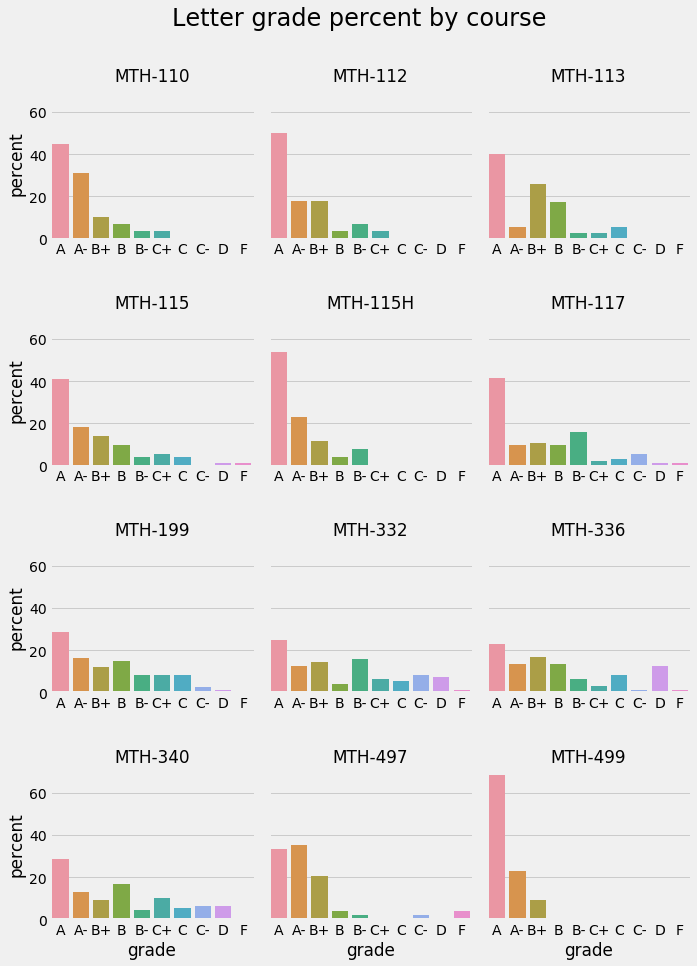

In [21]:
# Graph percent of letter grade by course
def mini_barplot(x, order, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    sns.barplot(y='percent', x='grade', 
                data=((data[x].value_counts(normalize=True) * 100)
                      .reset_index()
                      .rename({'grade':'percent', 'index':'grade'}, axis=1)),
                order=uc.grade_rank)
    
g = sns.FacetGrid(grades.loc[grades.course.isin(uc.courses_select)],
                  col='course', col_wrap=3, height=3.2,
                  col_order=uc.courses_select,
                  sharex=False)

g = (g.map_dataframe(mini_barplot, 'grade', order=uc.grade_rank, data=grades)
     .set_titles('{col_name}')
     .set_axis_labels('grade', 'percent')
     .fig.subplots_adjust(hspace=0.5)
    )

plt.suptitle('Letter grade percent by course', y=1.05, fontsize=24)
plt.show()

In [22]:
# Grade point by course
with pd.option_context('display.float_format', '{:,.2f}'.format,
                       'max_rows', 15):
    display(grades
            .loc[grades.course.isin(uc.courses_select)]
            .groupby('course')
            .point.agg('describe')[['count', 'mean', 'std', 'min', 'max']])

,count,mean,std,min,max
course,,,,,
MTH-110,29.00,3.66,0.45,2.30,4.00
MTH-112,28.00,3.63,0.49,2.30,4.00
MTH-113,35.00,3.43,0.59,2.00,4.00
MTH-115,71.00,3.41,0.78,0.00,4.00
MTH-115H,26.00,3.71,0.41,2.70,4.00
MTH-117,94.00,3.30,0.82,0.00,4.00
MTH-199,109.00,3.22,0.74,1.00,4.00
MTH-332,96.00,2.95,0.98,0.00,4.00
MTH-336,95.00,2.95,1.02,0.00,4.00


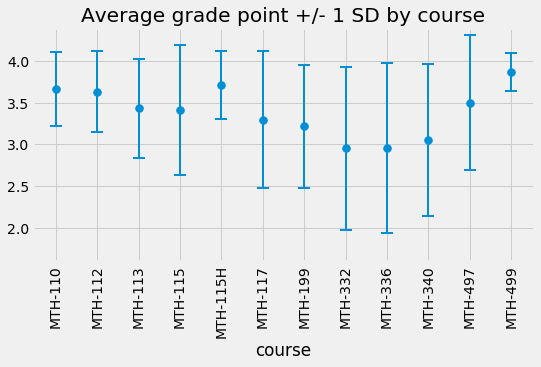

In [24]:
# Grade point by course - mean and SD
(grades
 .loc[grades.course.isin(uc.courses_select)]
 .groupby('course')
 .point.agg(['mean', 'std'])
 .reset_index()
 .plot('course', 'mean',
       yerr='std', elinewidth=2, capsize=6, capthick=2,
       linestyle='None', marker='.', markersize=15,
       figsize=(8, 4),
       ylim=(1.6, 4.4),
       legend=None
      )
)
plt.xticks(np.arange(len(uc.courses_select)), uc.courses_select, 
           rotation='vertical')
plt.title('Average grade point +/- 1 SD by course')
plt.show()

### Grade point by year

* Grade point appears, probably falsely, to decrease slightly over time 
  + Most recent grades dominated by more advanced courses (i.e. no one taking intro classes in 2018 is likely to have graduated yet).
  + Oldest grades dominated by intro courses and have fewer observations
    * Years 2006, 2007, 2008 and 2009 have 4 total observations between them

In [25]:
# Grade point by year summary statistics
with pd.option_context('display.float_format', '{:,.2f}'.format,
                       'max_rows', 12):
    display(grades.groupby('year').point
                .agg('describe')[['count', 'mean', 'std', 'min', 'max']])

,count,mean,std,min,max
year,,,,,
2006,1.00,4.00,nan,4.00,4.00
2007,1.00,4.00,nan,4.00,4.00
2008,2.00,4.00,0.00,4.00,4.00
2010,22.00,3.38,0.54,2.00,4.00
2011,77.00,3.47,0.62,2.00,4.00
2012,139.00,3.39,0.73,0.00,4.00
2013,211.00,3.37,0.71,1.00,4.00
2014,240.00,3.33,0.82,0.00,4.00
2015,212.00,3.15,0.95,0.00,4.00


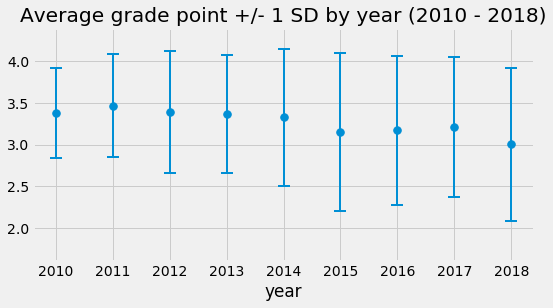

In [26]:
# Grade point by year - mean and SD
(grades
 .loc[grades['year'] > 2009]
 .groupby('year')
 .point.agg(['mean', 'std'])
 .reset_index()
 .plot('year', 'mean',
       yerr='std', elinewidth=2, capsize=6, capthick=2,
       linestyle='None', marker='.', markersize=15,
       figsize=(8, 4),
       ylim=(1.6, 4.4),
       legend=None
      )
)
plt.title('Average grade point +/- 1 SD by year (2010 - 2018)')
plt.show()

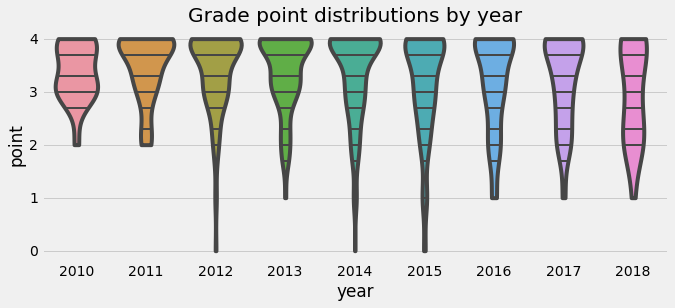

In [27]:
# Grade point by year distribution
plt.figure(figsize=(10, 4))
sns.violinplot(x='year', y='point',
               data=grades.loc[grades['year'] > 2009],
               inner='sticks',
               scale='area',     #  Each bin has same area
               # scale='count',  #  Bin width scaled by number of observations
               cut=0)
plt.title('Grade point distributions by year')
plt.show()

### Student grade by Course
* Can follow individual students, but might be too large to be useful
* Also somewhat sparse
  + including less courses makes reading easier, but reduces information
  + the second heat map is the same with less courses included
  + the following set of heat maps are the same but broken down by class
* Students who failed and retook a course reported using their average grade point for the course

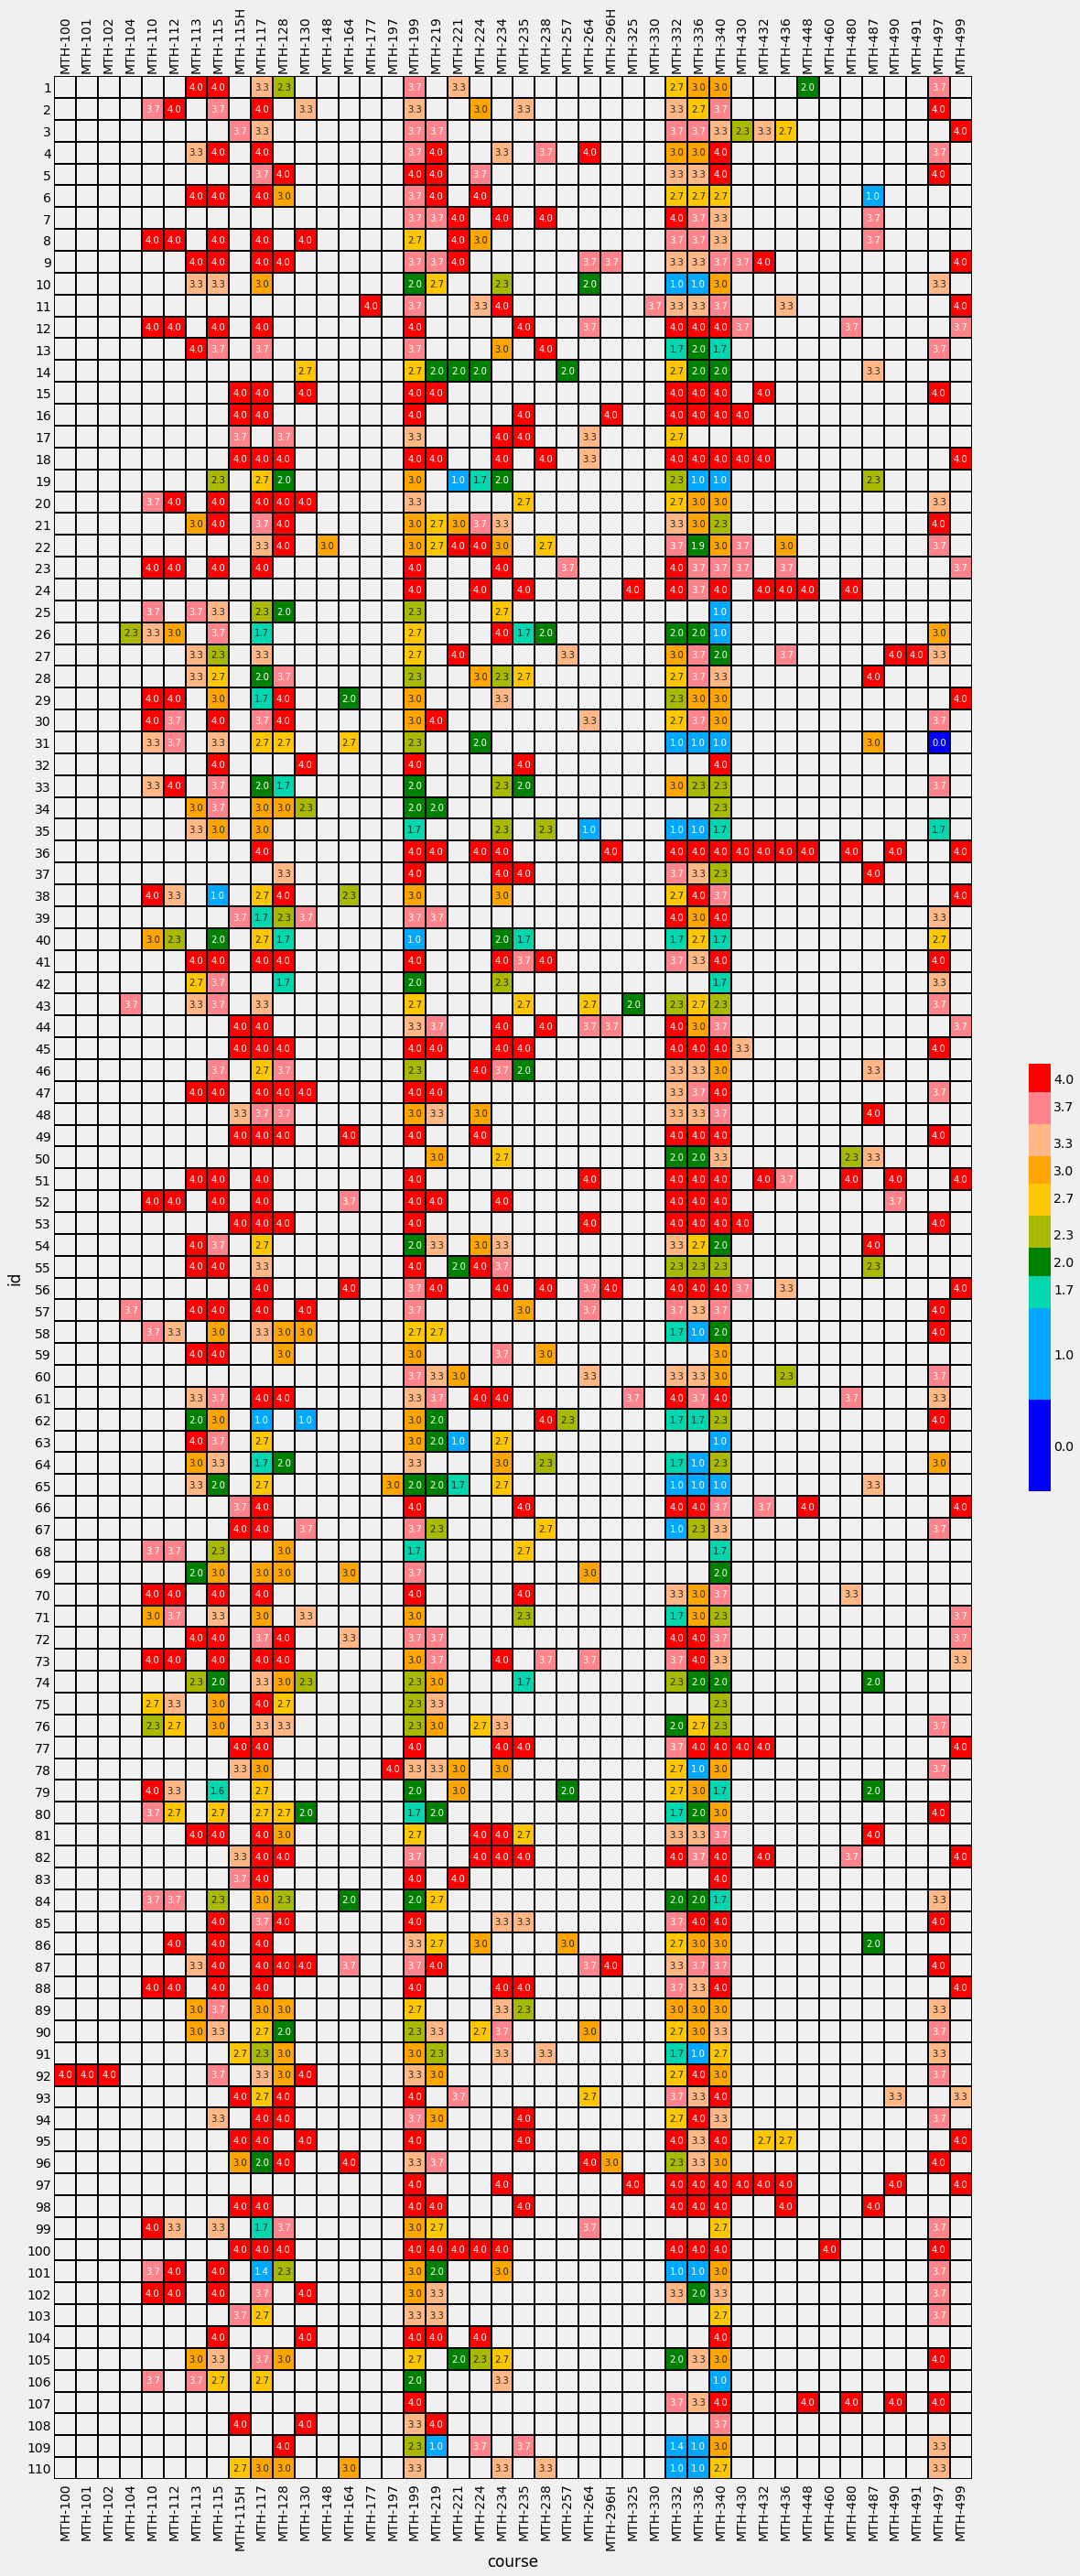

In [28]:
# Grades by student by course - showing all classes
min_count = 1    # exclude courses taken less than min_count times
include = ['MTH-100', 'MTH-101', 'MTH-102']  # include regardles of time taken

graph_data = (grades
              .groupby('course')
              .filter(lambda group: (len(group) >= min_count) | 
                                    (group.course.max() in include))
              .pivot_table('point', 'id', 'course', aggfunc='mean'))

include = graph_data.columns   # For use in graphing by class (next cell) 

fig = plt.figure(figsize=(20, 50))
colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
norm = plt_colors.BoundaryNorm(bounds, cmap.N)

ax = (sns.heatmap(graph_data, 
                  vmin=0, vmax=4,
                  cmap=cmap,
                  cbar_kws={'shrink':0.16, 'cmap':cmap, 'norm':norm,
                            'ticks':uc.point_rank,
                            'spacing':'proportional', 
                            'format':'%.1f'},
                  linewidth=1, linecolor='black',
                  annot=True, fmt='.1f', annot_kws={'fontsize':10},
                  square=True,
                  norm=norm
                )
     )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.show()

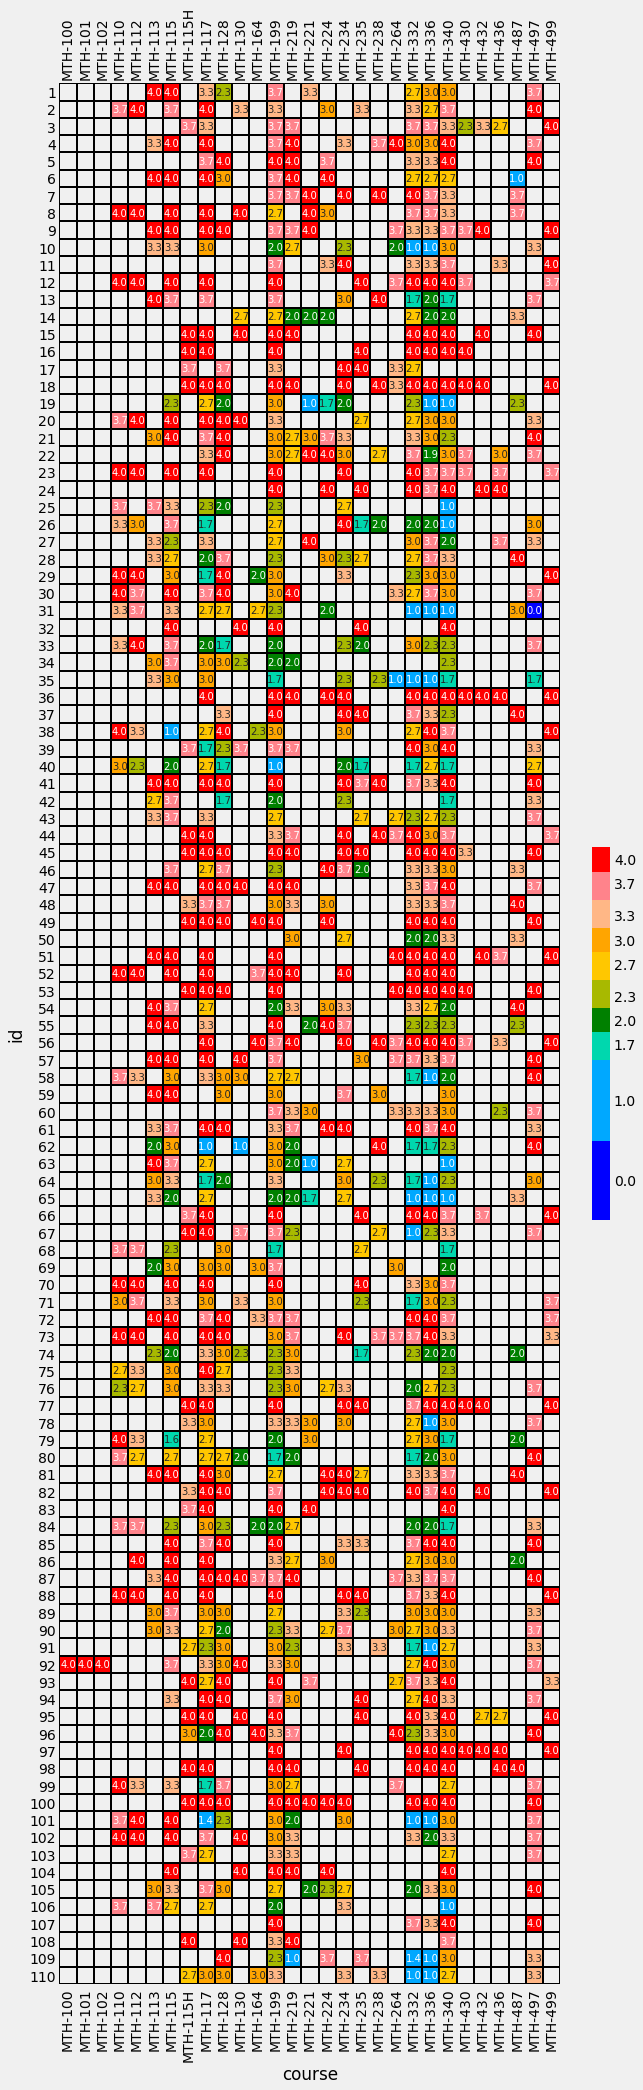

In [29]:
# Grades by student by course 
#   showing courses taken more at least 10 times across all class years
#   and MTH-100, 101 and 102 regardless
min_count = 10    # exclude courses taken less than min_count times
include = ['MTH-100', 'MTH-101', 'MTH-102']  # include regardles of time taken

graph_data = (grades
              .groupby('course')
              .filter(lambda group: (len(group) >= min_count) | 
                                    (group.course.max() in include))
              .pivot_table('point', 'id', 'course', aggfunc='mean'))

include = graph_data.columns   # For use in graphing by class (next cell) 

fig = plt.figure(figsize=(10, 40))
colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
norm = plt_colors.BoundaryNorm(bounds, cmap.N)

ax = (sns.heatmap(graph_data, 
                  vmin=0, vmax=4,
                  cmap=cmap,
                  cbar_kws={'shrink':0.16, 'cmap':cmap, 'norm':norm,
                            'ticks':uc.point_rank,
                            'spacing':'proportional', 
                            'format':'%.1f'},
                  linewidth=1, linecolor='black',
                  annot=True, fmt='.1f', annot_kws={'fontsize':10},
                  square=True,
                  norm=norm
                )
     )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.show()

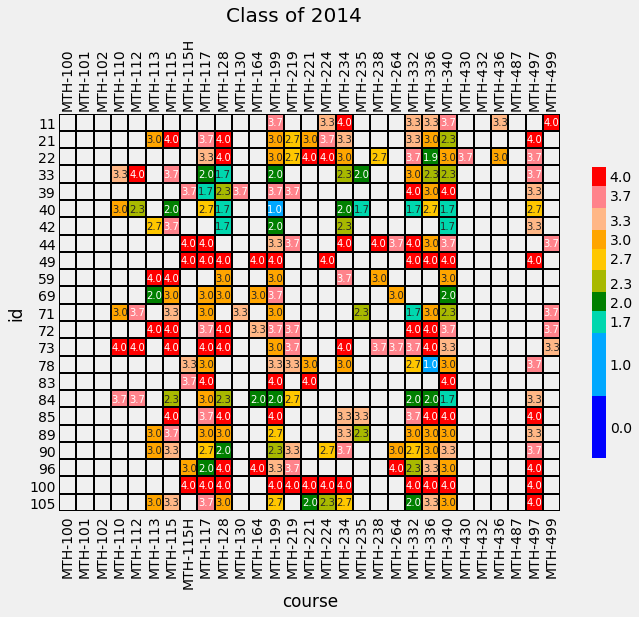

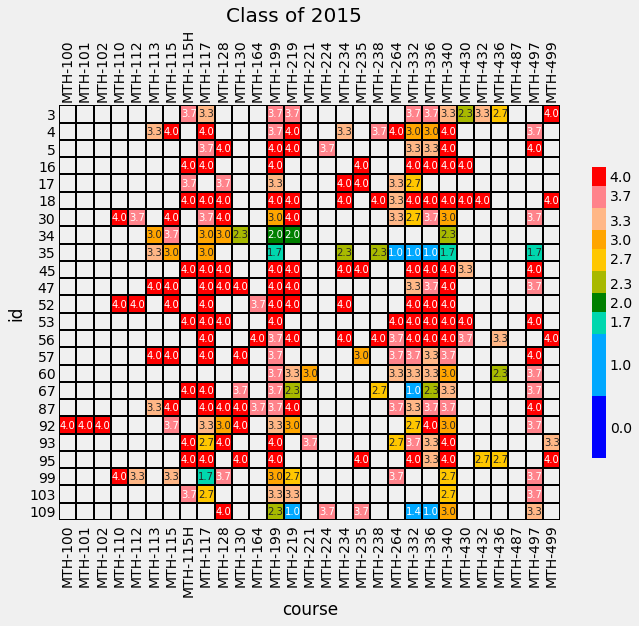

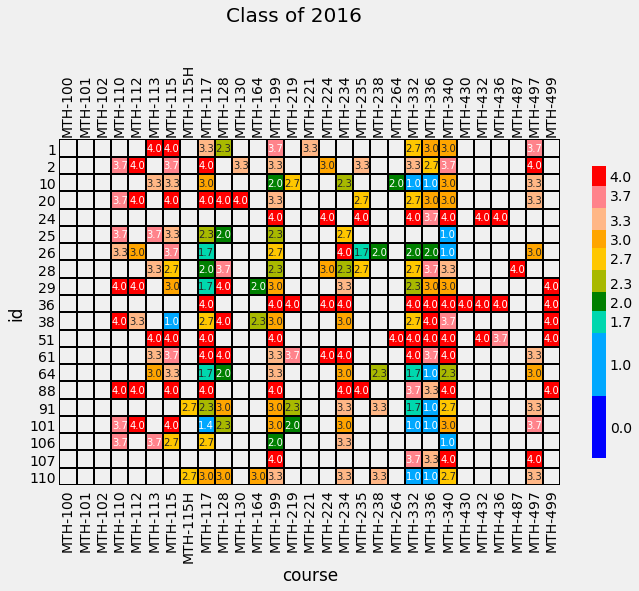

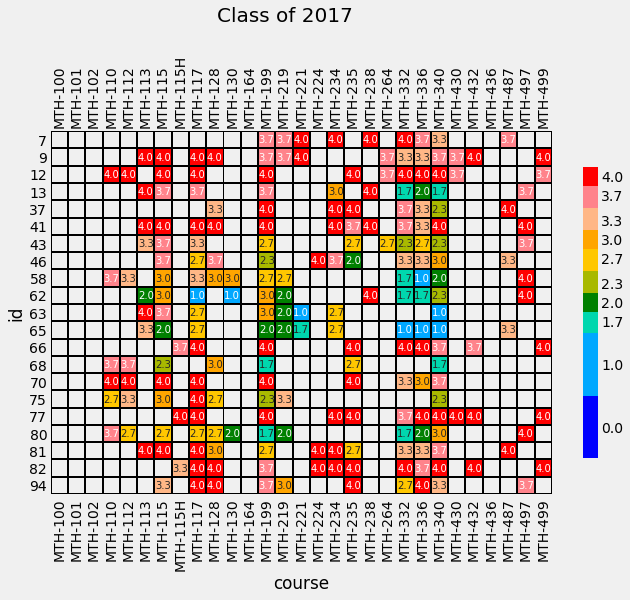

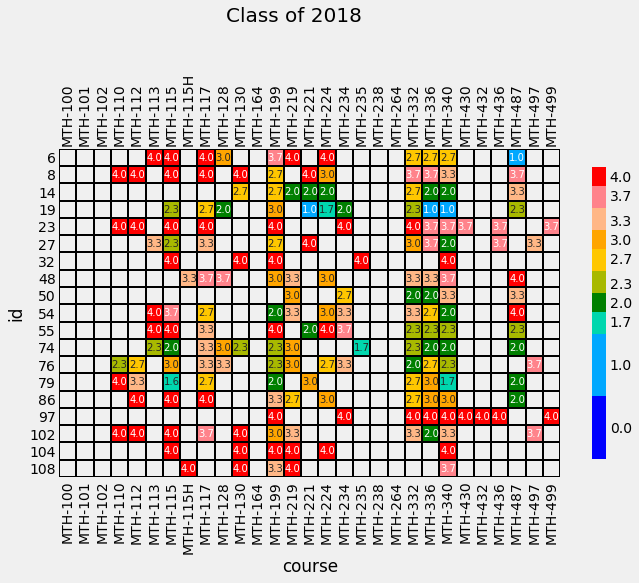

In [30]:
# Grades by student by course by class
#   showing courses taken at least 10 times across all years
#   and MTH-100, 101 and 102 regardless
class_years = [2014, 2015, 2016, 2017, 2018]

graph_data = (grades
              .groupby('course')
              .filter(lambda group: (group.course.max() in include))
              .pivot_table('point', 'id', 'course', aggfunc='mean', 
                           dropna=False))

for class_year in class_years:
    class_ids = info.loc[info.class_year == class_year].id.values
    graph_data_year = (graph_data.loc[graph_data.index.isin(class_ids)])

    fig = plt.figure(figsize=(10, 10))
    colors = ['blue', 'cyan', 'green', 'gold', 'orange', 'pink', 'red']  
    cmap = plt_colors.LinearSegmentedColormap.from_list('custom_cb', colors)
    bounds=[-0.5, 0.5, 1.5, 1.85, 2.15, 2.5, 2.85, 3.15, 3.5, 3.85, 4.15]
    norm = plt_colors.BoundaryNorm(bounds, cmap.N)

    ax = (sns.heatmap(graph_data_year, 
                      vmin=0, vmax=4,
                      cmap=cmap,
                      cbar_kws={'shrink':0.5, 'cmap':cmap, 'norm':norm,
                                'ticks':uc.point_rank,
                                'spacing':'proportional', 
                                'format':'%.1f'},
                      linewidth=1, linecolor='black',
                      annot=True, fmt='.1f', annot_kws={'fontsize':10},
                      square=True,
                      norm=norm
                    )
         )

    ax.xaxis.set_tick_params(labeltop=True)
    plt.xticks(rotation=90)
    plt.suptitle('Class of {0}'.format(class_year), ha='right', size=20, y=0.9)
    plt.show()